<a href="https://colab.research.google.com/github/TMhdSofyan/KAUST-Hackathon-EnergyHarvest/blob/main/09_UpdateNeuralNetwork_EarlyStopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [214]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
! pip install jcopml

In [6]:
! pip install jcopdl==1.1.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17913 sha256=785e63e73dd46e0b1ad522625b938cc72344c7bcc7d0ef0bdd94442f44a3bcf7
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl


In [ ]:
! pip install luwiji

In [215]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [216]:
df = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/03_Training_df2.csv')

In [134]:
df.head()

case_num  days     years  oil_prod_rate  oil_prod_cum  water_inj_rate  \
0         0     0  0.000000            0.0             0            0.00   
1         0    31  0.084932        26614.0        825035         1740.71   
2         0    62  0.169863        21427.7       1489290         1740.71   
3         0    93  0.254795        18809.7       2072390         1740.71   
4         0   124  0.339726        16676.6       2589370         1740.71   

   water_inj_cum category      Kh_Kv     inj_rate  permeability  porosity  \
0            0.0    train  16.423475  1740.711355    288.983333  0.163009   
1        53962.1    train  16.423475  1740.711355    288.983333  0.163009   
2       107924.0    train  16.423475  1740.711355    288.983333  0.163009   
3       161886.0    train  16.423475  1740.711355    288.983333  0.163009   
4       215848.0    train  16.423475  1740.711355    288.983333  0.163009   

     prod_bhp  thickness  
0  796.992254  23.718632  
1  796.992254  23.718632  
2  796.992254  23.718632  
3  796.992254  23.718632  
4  796.992254  23.718632

In [89]:
df['oil_prod_cum_10e5'] = df['oil_prod_cum'] / 100000

In [217]:
df.set_index('case_num', inplace=True)

In [227]:
X = df.drop(columns=["oil_prod_rate", 'days', 'oil_prod_cum', 'water_inj_rate', 'water_inj_cum', 'category']) #'oil_prod_cum_10e5'])
y = df.oil_prod_cum.values #For convert this value from DataFrame to Array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62250, 7), (20750, 7), (62250,), (20750,))

#Sample Data

In [219]:
X.head() #X data is still in DataFrame format

years      Kh_Kv     inj_rate  permeability  porosity  \
case_num                                                             
0         0.000000  16.423475  1740.711355    288.983333  0.163009   
0         0.084932  16.423475  1740.711355    288.983333  0.163009   
0         0.169863  16.423475  1740.711355    288.983333  0.163009   
0         0.254795  16.423475  1740.711355    288.983333  0.163009   
0         0.339726  16.423475  1740.711355    288.983333  0.163009   

            prod_bhp  thickness  
case_num                         
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632

In [230]:
preprocessor = ColumnTransformer([
    ('numeric1', num_pipe(scaling = 'minmax'), ['inj_rate', 'prod_bhp', 'permeability']),
    ('numeric2', num_pipe(), ['Kh_Kv', 'years', 'porosity', 'thickness'])
])

In [231]:
X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

In [174]:
#This step can be skipped if we have performed the two step above

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [235]:
y_test #now the data is converted into array

array([14864700,  9161320, 22984000, ..., 45277700, 17144700,  1470060])

---------------------------------------------

#STEP 1: DATASET & DATALOADER
Data loader --> aims to create the mini batch

In [236]:
import torch
from torch. utils.data import DataLoader, TensorDataset

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [237]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [238]:
# Create dataset (train & test) with the tensor data above and also create dataloader 
train_set = TensorDataset (X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

In [98]:
train_set[:5]

(tensor([[0.2805, 0.7662, 0.2506, 0.1330, 0.3310, 0.7402, 0.5776],
         [0.8293, 0.3292, 0.5925, 0.6938, 0.1274, 0.0145, 0.0802],
         [0.2561, 0.8989, 0.7840, 0.9963, 0.6384, 0.4654, 0.7463],
         [0.6585, 0.0957, 0.8624, 0.8319, 0.7530, 0.2110, 0.7686],
         [0.8902, 0.1976, 0.6626, 0.7750, 0.9389, 0.6230, 0.6626]]),
 tensor([117.1780,  83.3404, 294.6890, 387.2940, 367.1870]))

-----------------------------------------------------------

#**Step 2 : Architecture and Configuration**

In [239]:
#import neural network
from torch import nn

In [240]:
from jcopdl.layers import linear_block
class NN(nn.Module):
    def __init__(self, input_size, n1, output_size, dropout = 0.3):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout = dropout),
            linear_block(n1, output_size)
        )
        
    def forward(self, x):
        return self.fc(x)

In [241]:
from jcopdl.callback import Callback, set_config

In [242]:
config = set_config({
    "input_size": 7,
    "n1": 4,
    "output_size": 1,
    "dropout": 0.3
})

____

#**Step 3: Training Preparation**
Prepare model, criterion, and optimizer

##Model

In [ ]:
help(Callback)

In [243]:
from torch import optim

model = NN(config.input_size, config.n1, config.output_size, config.dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.005 )
callback = Callback(model, config, early_stop_patience=7, outdir = 'model')

-------------------

#**Step 4: Training Loop**

In [244]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):   #feature = X , Target = y
        feature, target = feature.to(device), target.to(device)
        output = model(feature) # model 
        loss = criterion(output, target) #criterion output vs target
        
        if mode == "train":
            loss.backward() #backpropagation
            optimizer.step() #update weigh
            optimizer.zero_grad() #reset optimizer to 0
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/973 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 391120627788522.3750 | Test_cost  = 386324297236222.5625 | 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 390745862079439.9375 | Test_cost  = 385813144666010.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 390126910822566.9375 | Test_cost  = 385120924806319.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 389372697003889.0000 | Test_cost  = 384318514048349.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 388531873050233.0000 | Test_cost  = 383446551935399.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 387618104823082.5000 | Test_cost  = 382522665162023.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 386683635838906.6250 | Test_cost  = 381572667704183.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 385720677813800.2500 | Test_cost  = 380602245011901.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 384732530550438.0625 | Test_cost  = 379616841577185.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 383733477301072.0625 | Test_cost  = 378630655261780.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 382780026334846.8125 | Test_cost  = 377649281567192.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 381801610485270.1875 | Test_cost  = 376681771043850.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 380874768825063.0625 | Test_cost  = 375722439625954.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 379871510247516.4375 | Test_cost  = 374771979191339.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 378976849987044.6250 | Test_cost  = 373848069086718.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 378069874398366.1250 | Test_cost  = 372941068248935.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 377157671096021.3750 | Test_cost  = 372060225120334.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 376205714950903.8125 | Test_cost  = 371191757623048.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 375435015871586.8750 | Test_cost  = 370360012419559.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 374620467307490.6250 | Test_cost  = 369550255812140.1875 | 


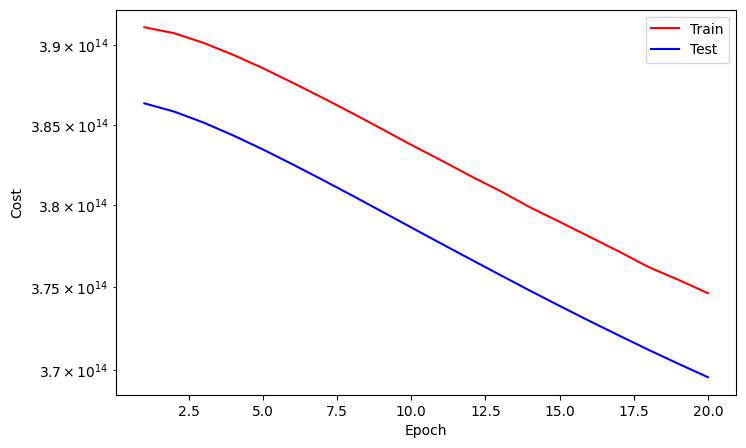

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 373818430763638.7500 | Test_cost  = 368769563526550.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 372913754829170.1875 | Test_cost  = 368001483865208.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 372392633100837.5000 | Test_cost  = 367282630816290.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 371670489972213.3125 | Test_cost  = 366584276572533.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 371047456967728.4375 | Test_cost  = 365914934988100.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 370337006598649.1250 | Test_cost  = 365256451954216.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 369696929433657.0625 | Test_cost  = 364625261361166.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 369129053438431.5625 | Test_cost  = 364024240791759.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 368490736772340.8750 | Test_cost  = 363440610777794.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 367923418567666.0000 | Test_cost  = 362883278913265.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 367333767846121.8125 | Test_cost  = 362341749953993.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 366794036587239.7500 | Test_cost  = 361827023356500.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 366432107205086.3750 | Test_cost  = 361350787537930.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 365826930320148.2500 | Test_cost  = 360873552453822.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 365358421679224.4375 | Test_cost  = 360426947763398.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 364943072313164.5000 | Test_cost  = 359991737543591.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 364649109722274.8750 | Test_cost  = 359587013564396.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 364126926745686.4375 | Test_cost  = 359195034292628.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 363735556129215.4375 | Test_cost  = 358817619604251.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 363443083472614.5000 | Test_cost  = 358461678012375.1250 | 


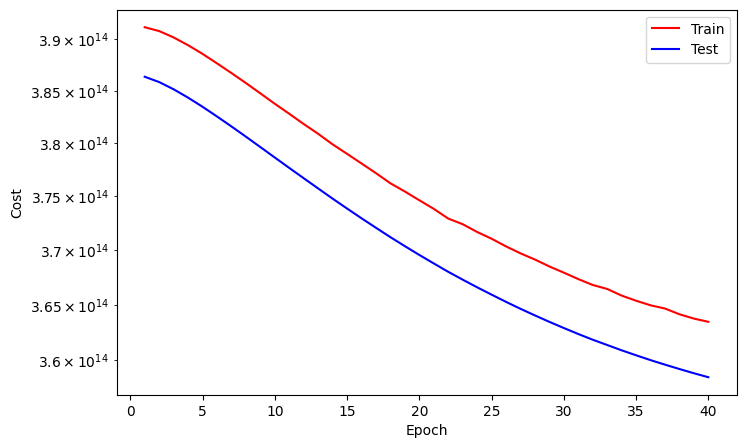

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 363135599862191.8750 | Test_cost  = 358121112280520.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 362705191513924.7500 | Test_cost  = 357786875771593.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 362525724117011.6875 | Test_cost  = 357483986029730.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 362237995671152.1875 | Test_cost  = 357188625397878.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 361936845664869.3750 | Test_cost  = 356902285471607.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 361775024657479.8125 | Test_cost  = 356635614458030.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 361358169530219.8125 | Test_cost  = 356373787714781.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 361051190791909.1875 | Test_cost  = 356118575402280.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 360970222929810.1875 | Test_cost  = 355892583531083.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 360659342813109.1875 | Test_cost  = 355662205702673.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 360425486440664.4375 | Test_cost  = 355449025498997.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 360204514584164.3125 | Test_cost  = 355244306549071.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 359904694545121.4375 | Test_cost  = 355043587339185.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 359833442336735.8750 | Test_cost  = 354865085134835.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 359562566435902.5000 | Test_cost  = 354683805283284.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 359565638527690.7500 | Test_cost  = 354524925930690.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 359237626329785.2500 | Test_cost  = 354359228149337.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 359337805076609.0625 | Test_cost  = 354219974164679.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 359025374096700.1250 | Test_cost  = 354066529692162.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 359056339206759.8750 | Test_cost  = 353938895515131.1875 | 


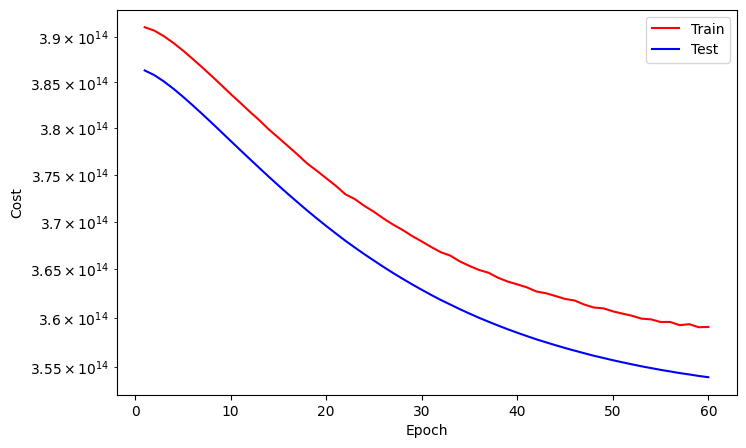

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 358841754615617.4375 | Test_cost  = 353812519873479.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 358569668918227.9375 | Test_cost  = 353677098713754.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 358513649157413.0625 | Test_cost  = 353563584099405.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 358501029171134.6250 | Test_cost  = 353452073979929.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 358297479423639.3750 | Test_cost  = 353343016804245.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 358260114823089.1250 | Test_cost  = 353243061492206.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 358081229034174.6250 | Test_cost  = 353139469778836.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 358098365884690.1875 | Test_cost  = 353052480048094.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 357983495550546.8125 | Test_cost  = 352969735607917.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 357758538758921.8125 | Test_cost  = 352872872898723.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 357721142351465.1875 | Test_cost  = 352795155627210.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 357662797178495.1250 | Test_cost  = 352716553443663.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 357730558909865.7500 | Test_cost  = 352652076010394.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 357649864345246.4375 | Test_cost  = 352586048676080.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 357544300686689.5000 | Test_cost  = 352521852097450.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 357375731110599.0000 | Test_cost  = 352454165916106.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 357427363595740.7500 | Test_cost  = 352400604038727.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 357390872120860.1250 | Test_cost  = 352348201944821.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 357187764678454.5000 | Test_cost  = 352287226999167.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 357223589756386.3125 | Test_cost  = 352235434693592.2500 | 


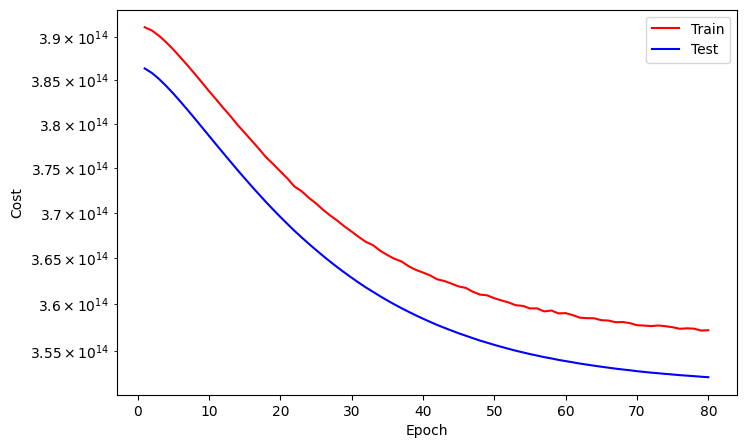

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 357183054187087.3125 | Test_cost  = 352187000897202.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 357062325745021.6250 | Test_cost  = 352139311824856.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 357061786877553.5000 | Test_cost  = 352096278490590.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 357046187534773.3750 | Test_cost  = 352052543938230.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 357026337873383.3125 | Test_cost  = 352015056234689.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 356878763310785.5625 | Test_cost  = 351977826229186.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 356990446585684.5625 | Test_cost  = 351947466250264.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 357011150960120.2500 | Test_cost  = 351907054773609.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 356738328661285.7500 | Test_cost  = 351867989691582.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 356913640482212.1875 | Test_cost  = 351841683637853.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 356750168454465.0625 | Test_cost  = 351810391631623.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 356797698991418.3750 | Test_cost  = 351784347687329.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 356883799192820.7500 | Test_cost  = 351771630282697.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 356754989324551.2500 | Test_cost  = 351739654982099.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 356652196960222.3750 | Test_cost  = 351712116816096.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 356829134824072.2500 | Test_cost  = 351702241767780.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 356578171022284.6875 | Test_cost  = 351669652713768.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 356535658894805.7500 | Test_cost  = 351646961502446.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 356510035087576.1875 | Test_cost  = 351618320978752.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 356477998627894.3750 | Test_cost  = 351600302484862.4375 | 


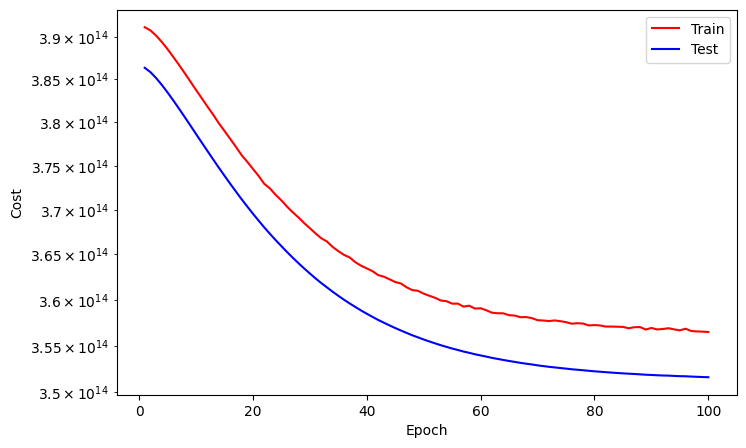

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 356584678601707.4375 | Test_cost  = 351595312036875.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 356525831289492.4375 | Test_cost  = 351576618127036.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 356684543990024.3125 | Test_cost  = 351573405129273.1250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 356431309646876.1875 | Test_cost  = 351548639435810.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 356585232983451.1875 | Test_cost  = 351538609186523.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 356431667149000.8750 | Test_cost  = 351516124664034.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 356422028761576.5625 | Test_cost  = 351502980537583.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 356648324713008.2500 | Test_cost  = 351502671558671.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 356558352359260.5625 | Test_cost  = 351491583718965.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 356453669220745.8750 | Test_cost  = 351480209222534.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 356393651075003.8750 | Test_cost  = 351465618177230.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 356416427991621.9375 | Test_cost  = 351450839945090.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 356211715187142.5625 | Test_cost  = 351432744588102.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 356515414315269.5000 | Test_cost  = 351438192068475.5625 | 
==> EarlyStop patience =  1 | Best test_cost: 351432744588102.9375


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 356342957203002.5000 | Test_cost  = 351430885268299.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 356409728490550.6250 | Test_cost  = 351420727554215.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 356368875737270.0000 | Test_cost  = 351411412358767.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 356405566986344.8125 | Test_cost  = 351411092914106.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 356239929972742.3750 | Test_cost  = 351390122167071.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 356419952957741.6875 | Test_cost  = 351399098150658.9375 | 


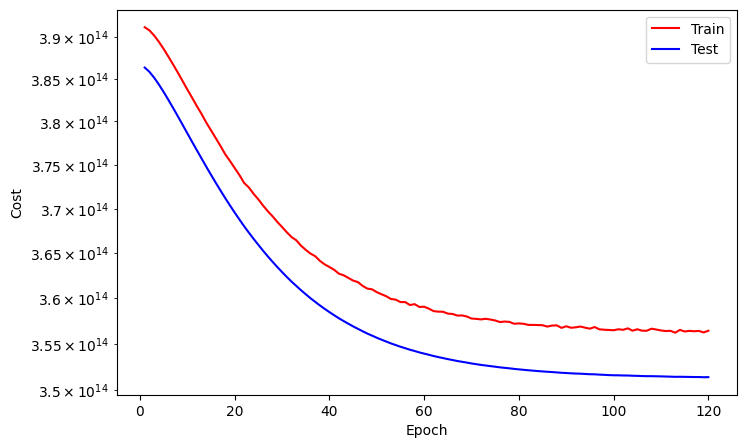

==> EarlyStop patience =  1 | Best test_cost: 351390122167071.2500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 356519719458317.5625 | Test_cost  = 351392649839413.1875 | 
==> EarlyStop patience =  2 | Best test_cost: 351390122167071.2500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 356490509850378.7500 | Test_cost  = 351389343794805.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 356386451043144.2500 | Test_cost  = 351383493971728.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 356554411599556.1250 | Test_cost  = 351390629535956.3750 | 
==> EarlyStop patience =  1 | Best test_cost: 351383493971728.3750


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 356391842824776.8125 | Test_cost  = 351376582554340.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 356369497557762.3125 | Test_cost  = 351367484177121.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 356307156975833.3750 | Test_cost  = 351362272072599.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 356376795251615.5000 | Test_cost  = 351354566965953.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 356212688527098.6250 | Test_cost  = 351343440639718.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 356300267262368.2500 | Test_cost  = 351342307712727.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 356448131066326.0000 | Test_cost  = 351341462846088.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 356301319375194.0625 | Test_cost  = 351335036410715.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 356362829136989.0000 | Test_cost  = 351337172193165.1250 | 
==> EarlyStop patience =  1 | Best test_cost: 351335036410715.6875


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 356378902953452.3125 | Test_cost  = 351329524428213.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 356319882699269.1875 | Test_cost  = 351321869761560.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 356261712171053.6875 | Test_cost  = 351316725936669.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 356228358607472.6875 | Test_cost  = 351307442241960.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 356337015909196.2500 | Test_cost  = 351307455307975.7500 | 
==> EarlyStop patience =  1 | Best test_cost: 351307442241960.8125


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 356256469981277.7500 | Test_cost  = 351306584108788.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 356321515308619.8125 | Test_cost  = 351311746116139.2500 | 


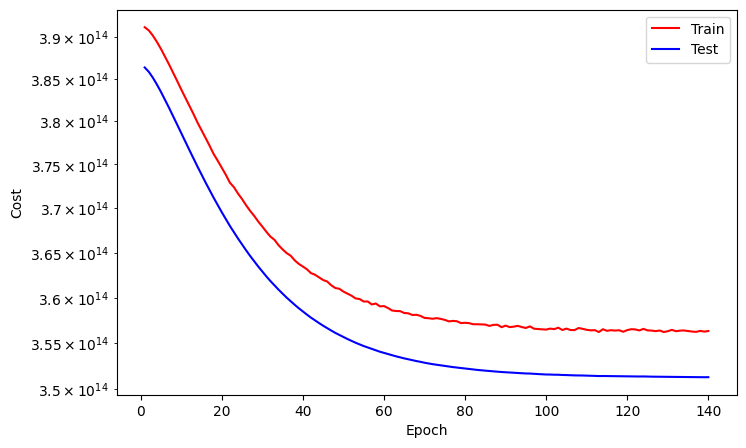

==> EarlyStop patience =  1 | Best test_cost: 351306584108788.7500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 356324609472486.5625 | Test_cost  = 351308834322362.3125 | 
==> EarlyStop patience =  2 | Best test_cost: 351306584108788.7500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 356434422002904.8125 | Test_cost  = 351315706289440.8750 | 
==> EarlyStop patience =  3 | Best test_cost: 351306584108788.7500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 356172642592695.8125 | Test_cost  = 351291224788272.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 356215518402783.2500 | Test_cost  = 351292002022113.0625 | 
==> EarlyStop patience =  1 | Best test_cost: 351291224788272.3125


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 356163618760757.6250 | Test_cost  = 351287439557268.1250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 356278355478727.1875 | Test_cost  = 351288683189628.3125 | 
==> EarlyStop patience =  1 | Best test_cost: 351287439557268.1250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 356229863216233.0000 | Test_cost  = 351293034030309.0625 | 
==> EarlyStop patience =  2 | Best test_cost: 351287439557268.1250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 356354697255161.0625 | Test_cost  = 351299134300432.4375 | 
==> EarlyStop patience =  3 | Best test_cost: 351287439557268.1250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 356182628439093.3750 | Test_cost  = 351293670655717.5000 | 
==> EarlyStop patience =  4 | Best test_cost: 351287439557268.1250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 356365199601022.4375 | Test_cost  = 351295629309575.9375 | 
==> EarlyStop patience =  5 | Best test_cost: 351287439557268.1250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 356169540427512.0000 | Test_cost  = 351289677209356.0000 | 
==> EarlyStop patience =  6 | Best test_cost: 351287439557268.1250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 356258511748790.5000 | Test_cost  = 351287110927586.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 356372819820615.0625 | Test_cost  = 351295894497933.1875 | 
==> EarlyStop patience =  1 | Best test_cost: 351287110927586.6875


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 356280192331884.0625 | Test_cost  = 351288444903031.5625 | 
==> EarlyStop patience =  2 | Best test_cost: 351287110927586.6875


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 356368886248835.9375 | Test_cost  = 351292912445218.3125 | 
==> EarlyStop patience =  3 | Best test_cost: 351287110927586.6875


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 356240419635667.9375 | Test_cost  = 351289747597660.4375 | 
==> EarlyStop patience =  4 | Best test_cost: 351287110927586.6875


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 356297413373029.8750 | Test_cost  = 351290924852077.2500 | 
==> EarlyStop patience =  5 | Best test_cost: 351287110927586.6875


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 356230544106540.3125 | Test_cost  = 351291977112596.4375 | 
==> EarlyStop patience =  6 | Best test_cost: 351287110927586.6875


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 356346215901632.9375 | Test_cost  = 351290068141936.5000 | 
==> EarlyStop patience =  7 | Best test_cost: 351287110927586.6875
==> Execute Early Stopping at epoch: 159 | Best test_cost: 351287110927586.6875
==> Best model is saved at model


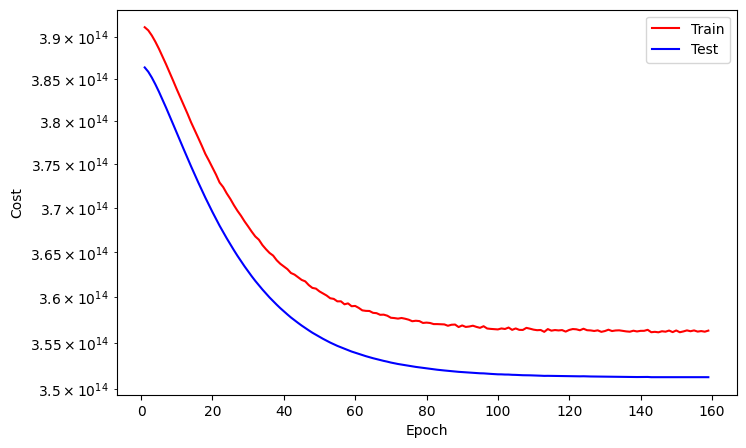

In [245]:
while True:
    train_cost= loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost= loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

#EVALUATION

In [246]:
with torch.no_grad():
    model.eval()
    output = model(X_test)
output.shape

torch.Size([20750, 1])

In [247]:
output = output.reshape(-1)
output

tensor([ 849325.5625, 1017541.2500,  696555.6875,  ..., 1975046.6250,
        1490512.2500, 1024091.6250])

In [248]:
y_test

tensor([14864700.,  9161320., 22984000.,  ..., 45277700., 17144700.,
         1470060.])

In [249]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test.numpy(), output.numpy())
mse

347410680000000.0

In [250]:
from sklearn.metrics import r2_score
test_r2 = r2_score(y_test.numpy(), output.numpy())
test_r2

-2.2943730429481874